Importing Nessesary libraries and modules from the local python environment

In [6]:
from math import sqrt,pi
from numpy import exp
from matplotlib import pyplot as plt
import numpy as np
import cv2
from matplotlib import cm
import pandas as pd
import pywt
from math import pi, sqrt

# Pre-processing

Loading Images and converting them to grey-Scale followed by adaptive hstogram equilisation
the final image matrix is stored in 1-D format to a new 2-D array

In [7]:
#img_rows=img_cols=200
immatrix=[]
im_unpre = []
#image_path = Image.open('C:\Users\Rohan\Desktop\Diabetic_Retinopathy\diaretdb1_v_1_1\diaretdb1_v_1_1\resources\images\ddb1_fundusimages\image0')
#image = misc.imread(image_path)

for i in range(1,90):
    img_pt = 'sample_data/Dataset/'
    if i < 10:
        img_pt = img_pt + "00" + str(i) + ".jpg"
    else:
        img_pt = img_pt + "0" + str(i)+ ".jpg"

    img = cv2.imread(img_pt)
    #im_unpre.append(np.array(img).flatten())
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(img_gray) 
    immatrix.append(np.array(equ).flatten())
    #res = np.hstack((img_gray,equ))

In [8]:
np.shape(np.array(equ).flatten())

(262144,)

Visualising a random image after the above steps the array contains 90 images

The shape of the image is determined from np.shape(equ) and those values are 1152,1500

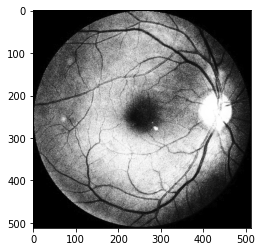

In [9]:
np.shape(immatrix)
np.shape(equ)
plt.imshow(immatrix[78].reshape((512,512)),cmap='gray')
plt.show()

Performing Discrete-Wavelet transform on the 2-D array available

 the Haar wavelet is a sequence of rescaled "square-shaped" functions which together form a wavelet family or basis. Wavelet analysis is similar to Fourier analysis in that it allows a target function over an interval to be represented in terms of an orthonormal basis. The Haar sequence is now recognised as the first known wavelet basis and extensively used as a teaching example.

In [10]:
imm_dwt = []
for equ in immatrix:
    equ = equ.reshape((512,512))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2).flatten())


Visualising a random image 

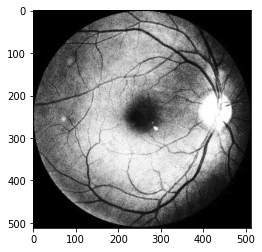

In [11]:
np.shape(imm_dwt)
np.shape(equ2)
plt.imshow(imm_dwt[78].reshape((512,512)),cmap='gray')
plt.show()

In [12]:
def _filter_kernel_mf_fdog(L, sigma, t = 3, mf = True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')
    
    ctr_x = dim_x / 2 
    ctr_y = int(dim_y / 2.)

    # an un-natural way to set elements of the array
    # to their x coordinate. 
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1) 

def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image, cmap = cm.Greys_r)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()


def gaussian_matched_filter_kernel(L, sigma, t = 3):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, True)

#Creating a matched filter bank using the kernel generated from the above functions
def createMatchedFilterBank(K, n = 12):
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels

#Given a filter bank, apply them and record maximum response

def applyFilters(im, kernels):

    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)


gf = gaussian_matched_filter_kernel(20, 5)
bank_gf = createMatchedFilterBank(gf, 4)

imm_gauss = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((512,512))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss.append(np.array(equ3).flatten())


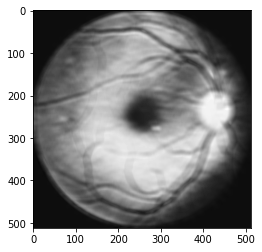

In [13]:
# the array ranges from 0 - 89
np.shape(imm_gauss)
plt.imshow(imm_gauss[78].reshape((512,512)),cmap='gray')
plt.show()

In [14]:
def createMatchedFilterBank():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 6, theta,12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

bank_gf = createMatchedFilterBank()
#equx=equ3
#equ3 = applyFilters(equ2,bank_gf)
imm_gauss2 = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((512,512))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss2.append(np.array(equ3).flatten())


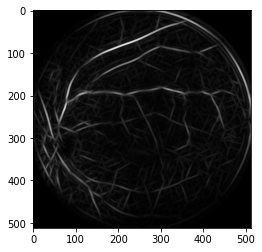

In [15]:
# the array ranges from 0 - 89
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[20].reshape((512,512)),cmap='gray')
plt.show()

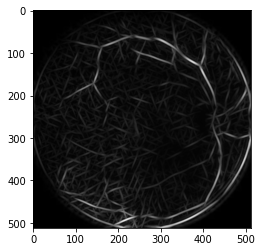

In [16]:
# the array ranges from 0 - 89
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[1].reshape((512,512)),cmap='gray')
plt.show()

In [17]:
e_ = equ3
np.shape(e_)
e_=e_.reshape((-1,4))
np.shape(e_)

(65536, 4)

Performing K-means Clusttering with PP centers(non random) neighbours on the final image

In [18]:
img = equ3
Z = img.reshape((-1,4))

# convert to np.float32
Z = np.float32(Z)

k=cv2.KMEANS_PP_CENTERS


# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

In [19]:
imm_kmean = []
for equ3 in imm_gauss2:
    img = equ3.reshape((512,512))
    Z = img.reshape((-1,4))

    # convert to np.float32
    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())



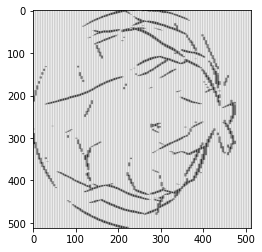

In [20]:
# the array ranges from 0 - 89
np.shape(imm_kmean)
plt.imshow(imm_kmean[78].reshape((512,512)),cmap="gray")
plt.show()

# Model training

In [24]:
from sklearn.svm import SVC
clf = SVC()

In [21]:
Y = np.ones(89)

In [22]:
Y[1]=Y[5]=Y[7]=Y[17]=Y[6]=0

In [25]:
clf.fit(imm_kmean, Y)

SVC()

In [26]:
y_pred = clf.predict(imm_kmean)

In [27]:
k = [1,3,4,9,10,11,13,14,20,22,24,25,26,27,28,29,35,36,38,42,53,55,57,64,70,79,84,86]

In [28]:
k = k-np.ones(len(k))

In [29]:
k

array([ 0.,  2.,  3.,  8.,  9., 10., 12., 13., 19., 21., 23., 24., 25.,
       26., 27., 28., 34., 35., 37., 41., 52., 54., 56., 63., 69., 78.,
       83., 85.])

In [30]:

k =[int(x) for x in k]


In [ ]:
k

In [32]:
imm_train = []
y_train = []
k.append(5)
k.append(7)
for i in k:
    imm_train.append(imm_kmean[i])
    y_train.append(Y[i])
    

In [ ]:
y_train

In [34]:
y_pred = clf.predict(imm_kmean)

In [35]:
from sklearn.neighbors import KNeighborsClassifier


In [36]:
neigh = KNeighborsClassifier(n_neighbors=3)


In [37]:
neigh.fit(imm_train, y_train) 

KNeighborsClassifier(n_neighbors=3)

In [38]:
y_pred2=neigh.predict(imm_kmean)


In [39]:
neigh.score(imm_kmean,Y)

0.9438202247191011

# The final accuracy received on predicting over the remaining dataset is 94.38% using KNN algo